Перебирая различную глубину дерева на один и тех же тестовых данных, мы не решаем проблему переобучения. Исправить ситуацию поможет  кросс-валидация (перекрёстная проверка), разбивающая данные на тренировочную выборку для обучения, валидирующее множество для подбора оптимальных параметров и тестовые данные для финального замера точности.

Что мы делаем:

1. Разделяем данные (X_train, y_train) на 5 частей, чтобы одну часть(всегда разную) использовать как тестовые данные, а остальные 4 как тренировочные. Получится, что каждый кусок данных будет использован и в обучении, и в тесте. Для каждой модели усредним accuracy на подвыборках, чтобы потом использовать как единый показатель точности для сравнения разных моделей.

```
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_train, y_train , cv=5) # array([0.74166667, 0.8     , 0.75630252, 0.79831933, 0.74576271])
cross_val_score(clf, X_train, y_train , cv=5).mean() # 0.7734524996439254
```

2.  Возвращаемся к работе с циклом для поиска оптимальной глубины и добавляем в scores_data среднюю точность на кросс-валидации. Чтобы не было путаницы в одном ноутбуке переименуем  scores_data в cross_val_scores_data.

```
cross_val_scores_data = pd.DataFrame()
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
   
    mean_cross_val_score = cross_val_score(clf, X_train, y_train , cv=5).mean()
   
    temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'train_score': [train_score],
                                    'test_score': [test_score],
                                    'cross_val_score': [mean_cross_val_score]})
    cross_val_scores_data = cross_val_scores_data.append(temp_score_data)
```

3. В результате получим датафрейм с колонкой max_depth и тремя score, используя функцию melt, преобразуем данные и построим график:

```
cross_val_scores_data_long = pd.melt(cross_val_scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
                          var_name='set_type', value_name='score')
sns.lineplot(x="max_depth", y="score", hue="set_type", data=cross_val_scores_data_long)
```

!График у всех будет немного отличаться, потому что  cross_val_score случайно разбивает данные на 5 частей!

4. Смотрим на зеленую линию (cross_val_score ). На графике ясно видно, что максимум приходится на глубину до 20. более точное значение максимальной глубины дерева поможет определить.

```
cross_val_scores_data_long.query("set_type == 'cross_val_score'").head(20)
```

! Тут тоже данные у всех будут отличаться, по той же причине !

5. Создаем классификатор, указывая соответствующее значение аргумента  max_depth. Обучаем на тренировочной выборке и замеряем точность на тестовой.

```
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)
best_clf.fit(X_train, y_train)
best_clf.score(X_test, y_test)
```

Тезисы, которые помогли разобраться в данном уроке, может кому тоже пригодится:

1. Перекрестная проверка не возвращает модель: кросс-валидация не является способом построения модели, которую можно применить к новым данным. При вызове ```cross_val_score``` строится несколько внутренних моделей, однако цель перекрёстной проверки заключается только в том, чтобы оценить обобщающую способность данного алгоритма, обучив на определённом наборе данных. ("Введение в машинное обучение с помощью Python. Руководство для специалистов по работе с данными" А.Мюллер, С.Гвидо)

2. При k-fold кросс-валидации обучающая выборка разбивается на (k-1) подвыборок и следующий алгоритм выполняется k раз:
* Модель обучается с использованием (k-1) подвыборок в качестве тренировочных данных;
* Полученная модель проверяется на оставшейся одной подвыборке (которая служит тестовым набором для вычисления точности). 

3. Модель – это набор подготовленных данных (переменных) + метод (статистики, машинного обучения), подобранные для достижения цели исследования (проекта Data Science)

Процесс моделирования включает:
1) Создание модели – планирование показателей (переменных) и выбор метода
2) Тренировка модели
3) Проверка адекватности и окончательный выбор модели
4) Применение тренированной модели к незнакомым данным
Хорошая модель будет найдена (вероятно) только после многократного повторения первых 3-х шагов. ("Основы Data Science и Big Data. Python и наука о данных" Д.Силен, А.Мейсман, М.Али)

Таким образом,
1. Нужна хорошая модель, которая позволит достичь целей проекта, которую нужно обучить, протестировать, оценить и окончательно выбрать, после чего её можно будет применять "на производстве"
2. В данном уроке модель – это предобработанные данные Titanic + метод моделирования "Дерево решений", модель обучается методом fit() и тестируется 2-мя способами: score и cross_val_score
3. Метод cross_val_score() содержит (условно) процедуры обучения (fit) и проверки (score) , но он не может возвращать модель, которую можно применять к новым данным.

In [1]:
from sklearn import tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [3]:
from IPython.display import HTML
style = "<style>svg{width:79% !important; height:70% !important;}</style>"
HTML(style)

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.model_selection import cross_val_score

In [6]:
titanic_data = pd.read_csv(r"D:\YandexDisk\datasets\titanic-train.csv")

In [7]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
X = titanic_data.drop({'PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'}, axis=1)

In [10]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [11]:
y = titanic_data.Survived

In [12]:
X = pd.get_dummies(X)

In [13]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [14]:
X = X.fillna({'Age':X.Age.median()})

In [15]:
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [16]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [18]:
X_train.shape

(596, 10)

In [19]:
X_test.shape

(295, 10)

In [20]:
clf.score(X, y)

0.9797979797979798

In [21]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [22]:
clf.score(X_train, y_train)

0.9798657718120806

In [23]:
clf.score(X_test, y_test)

0.7796610169491526

In [24]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [25]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [26]:
clf.score(X_train, y_train)

0.8238255033557047

In [27]:
clf.fit(X_test, y_test)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [28]:
clf.score(X_test, y_test)

0.8169491525423729

In [29]:
max_depth_values = range(1, 100)

In [30]:
scores_data = pd.DataFrame()

In [31]:
for max_depth in max_depth_values:
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score], 
                                    'test_score':[test_score],
                                    'cross_val_score':[mean_cross_val_score]})
    
    scores_data = scores_data.append(temp_score_data)

In [32]:
scores_data.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.810169,0.795350


In [33]:
scores_data_long = pd.melt(scores_data, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
                          var_name='set_type', value_name='score')

In [34]:
scores_data_long

,max_depth,set_type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604
...,...,...,...
292,95,cross_val_score,0.761779
293,96,cross_val_score,0.765154
294,97,cross_val_score,0.771863
295,98,cross_val_score,0.763459


<AxesSubplot:xlabel='max_depth', ylabel='score'>

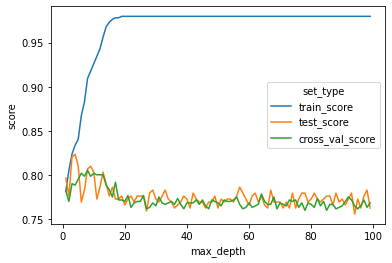

In [35]:
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

In [36]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [37]:
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.7886274509803922

In [38]:
scores_data_long.query("set_type == 'cross_val_score'").head(20)

,max_depth,set_type,score
198,1,cross_val_score,0.781961
199,2,cross_val_score,0.770196
200,3,cross_val_score,0.790322
201,4,cross_val_score,0.788627
202,5,cross_val_score,0.795350
203,6,cross_val_score,0.802073
204,7,cross_val_score,0.798697
205,8,cross_val_score,0.805406
206,9,cross_val_score,0.798669
207,10,cross_val_score,0.802031


In [39]:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [40]:
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [41]:
best_clf.score(X_test, y_test)

0.8067796610169492

In [42]:
cross_val_score(best_clf, X_test, y_test, cv=5).mean()

0.7864406779661016

In [43]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import tree

In [44]:
clf = tree.DecisionTreeClassifier()

In [45]:
params = {'criterion':['gini', 'entropy'], 'max_depth':range(1,30)}

In [46]:
grid_search_cv_clf = GridSearchCV(clf, params, cv=5)

In [47]:
grid_search_cv_clf

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [48]:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [49]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 12}

In [50]:
best_clf = grid_search_cv_clf.best_estimator_

In [51]:
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=12)

In [52]:
best_clf.score(X_test, y_test)

0.7661016949152543

In [53]:
from sklearn.metrics import precision_score, recall_score

In [54]:
y_pred = best_clf.predict(X_test)

In [55]:
precision_score(y_test, y_pred)

0.7297297297297297

In [56]:
recall_score(y_test, y_pred)

0.675

In [57]:
y_predicted_prob = best_clf.predict_proba(X_test)

In [58]:
y_predicted_prob

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.80952381, 0.19047619],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.16666667, 0.83333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.6       , 0.4       ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.6       , 0.4       ],
       [0.93877551, 0.06122449],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.25      , 0.75      ],
       [0.6       , 0.4       ],
       [0.80952381, 0.19047619],
       [0.93877551, 0.06122449],
       [1.        , 0.        ],
       [0.25      , 0.75      ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.

<AxesSubplot:>

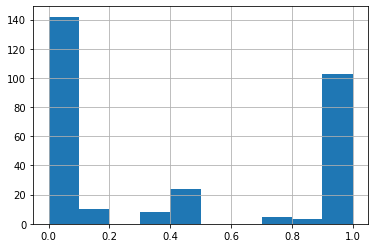

In [59]:
pd.Series(y_predicted_prob[:,1]).hist()

In [60]:
y_pred = np.where(y_predicted_prob[:,1] > 0.8, 1, 0)

In [61]:
precision_score(y_test, y_pred)

0.7452830188679245

In [62]:
recall_score(y_test, y_pred)

0.6583333333333333

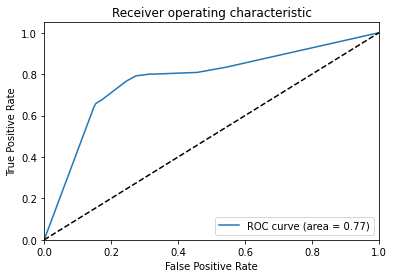

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from sklearn.datasets import make_classification

fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

# ***

In [64]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100, min_samples_leaf=10)

In [65]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10,
                       min_samples_split=100)

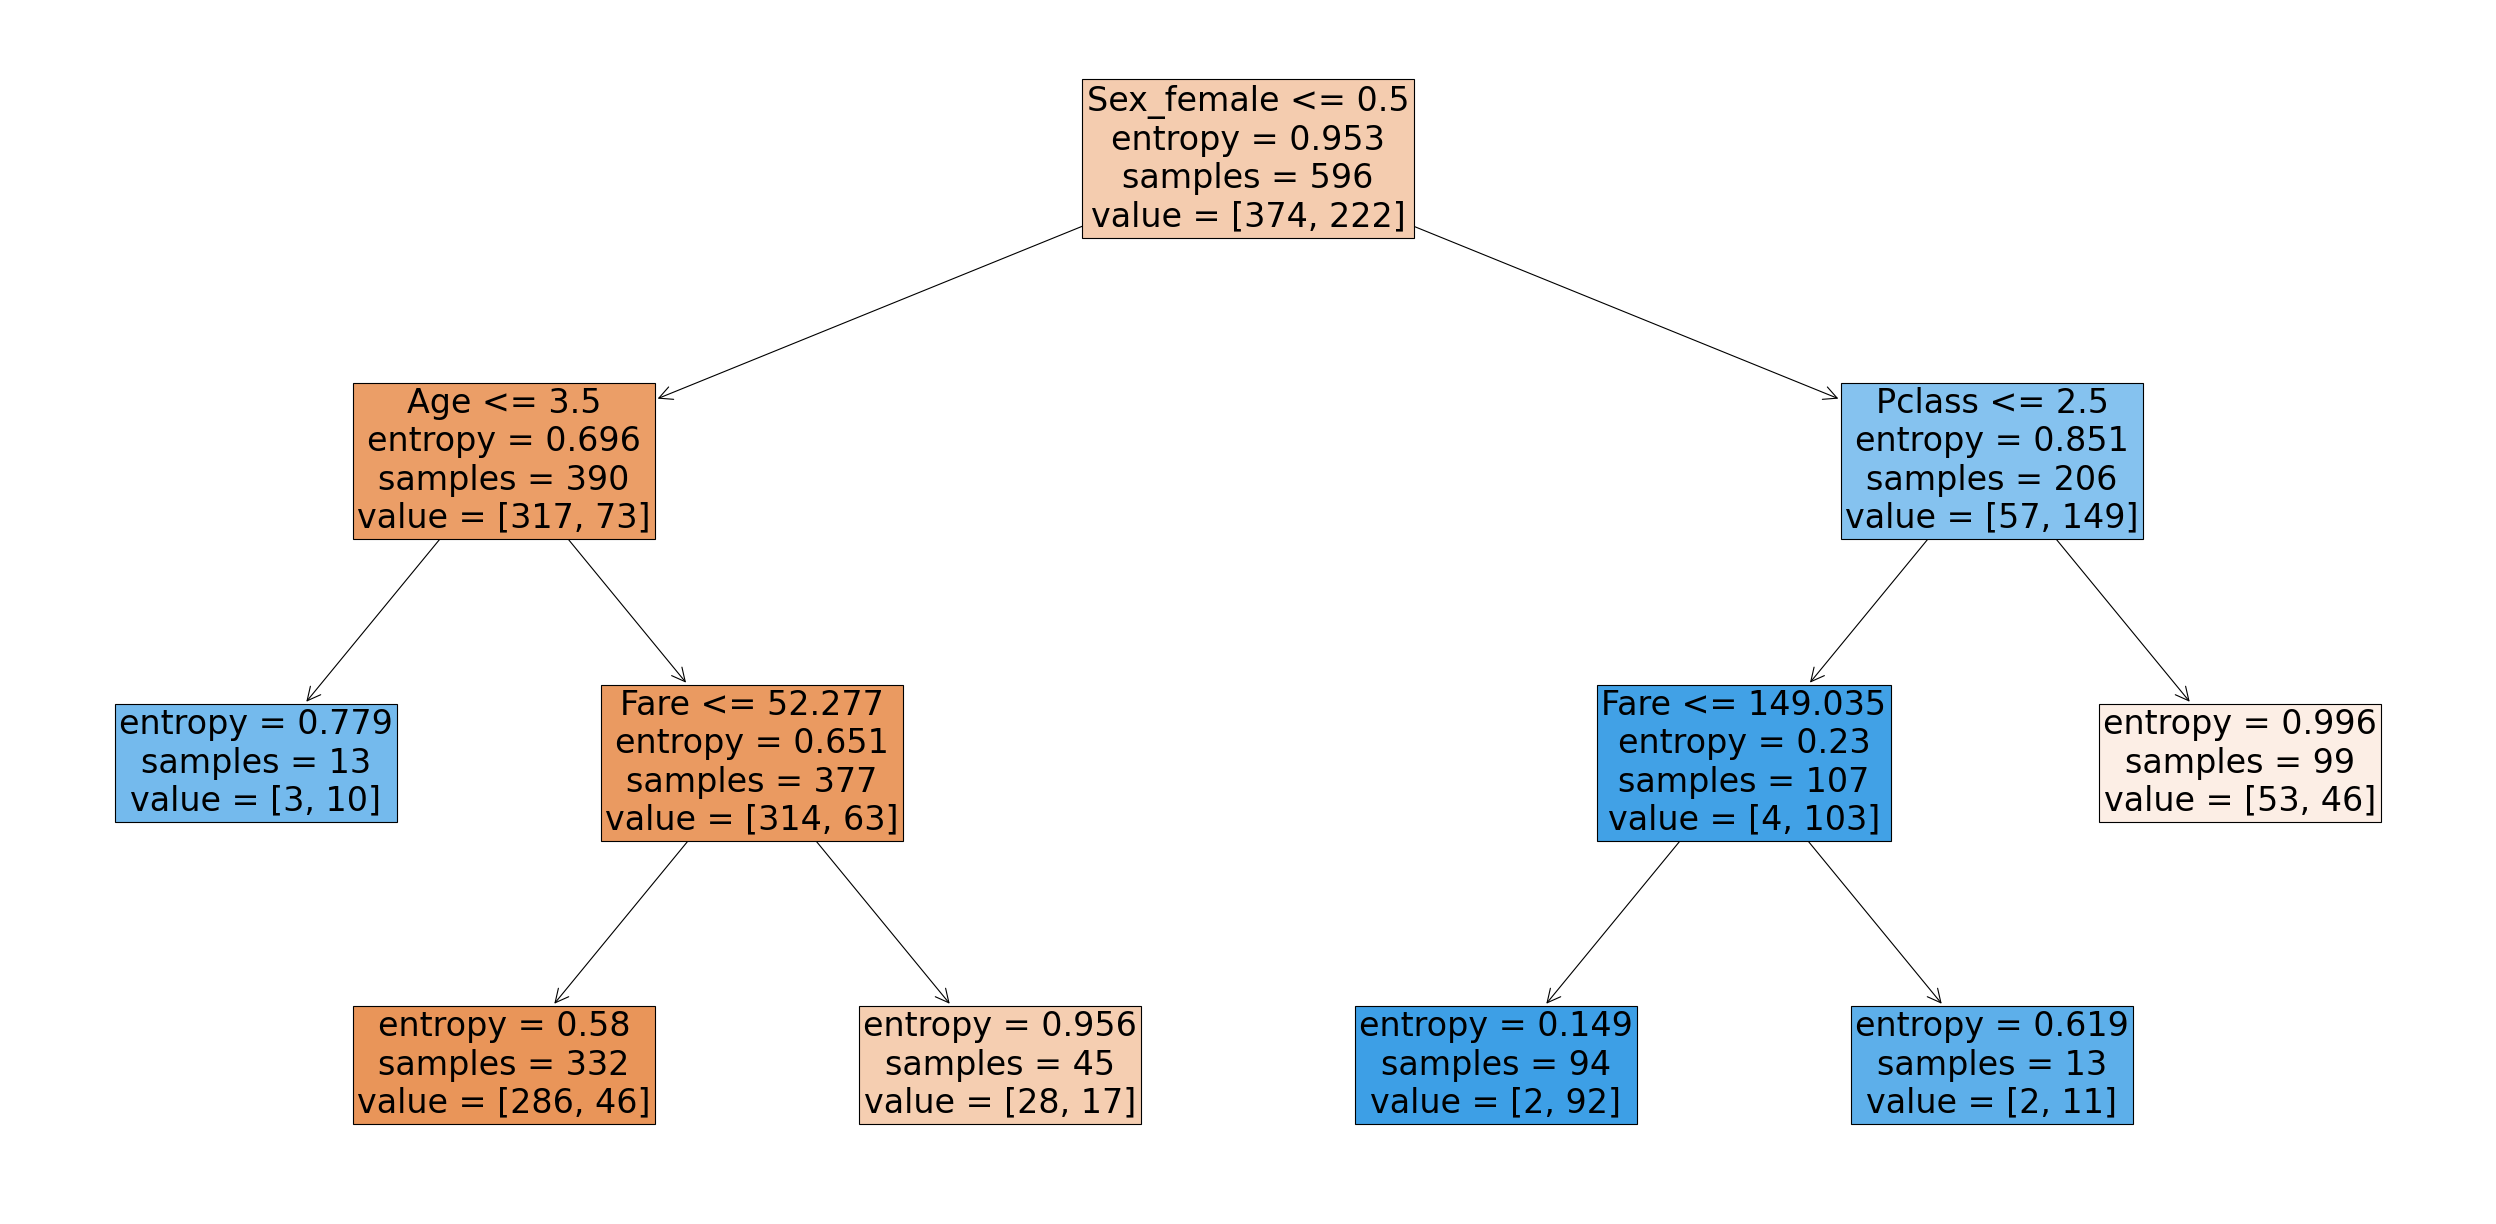

In [66]:
plt.figure(figsize=(40, 20),dpi=80)
p = tree.plot_tree(clf, fontsize=30,filled=True,feature_names=list(X))